In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
k=2

### Dataset import

In [8]:
cho = pd.read_csv(r"C:\Users\Byeke\OneDrive\Documents\Spring_2022_Lehigh\data_mining\project_1\Datasets\cho.txt",delimiter='\t',header=None)
elliptical = pd.read_csv(r"C:\Users\Byeke\OneDrive\Documents\Spring_2022_Lehigh\data_mining\project_1\Datasets\elliptical.txt",delimiter=' ',names = ['x','y'])
iyer = pd.read_csv(r"C:\Users\Byeke\OneDrive\Documents\Spring_2022_Lehigh\data_mining\project_1\Datasets\iyer.txt",delimiter='\t',header=None)
square = pd.read_csv(r"C:\Users\Byeke\OneDrive\Documents\Spring_2022_Lehigh\data_mining\project_1\Datasets\square.txt",delimiter=' ',names = ['x','y'])

#### Rename cho and iyer columns

In [100]:

real_set_cols = cho.columns.tolist()
real_set_cols[0] = "gene_id"
real_set_cols[1] = "ground_truth"
cho.columns = real_set_cols
cho.set_index('gene_id',inplace=True)

real_set_cols = iyer.columns.tolist()
real_set_cols[0] = "gene_id"
real_set_cols[1] = "ground_truth"
iyer.columns = real_set_cols
iyer.set_index('gene_id',inplace=True)

### Simulation Dataset

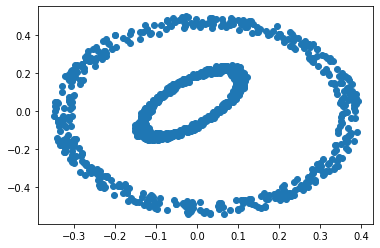

In [10]:
# plt.scatter(square.loc[:,"x"],square.loc[:,"y"])
plt.scatter(elliptical.loc[:,"x"],elliptical.loc[:,"y"])

In [10]:
tol = .001
k=2
np_square = np.array(square)
np_elliptical = np.array(elliptical)

#### Build Kmeans

In [333]:
def distance(a,b):
    """
    Return euclidean distance between np.arrays a and b
    """
    return np.sqrt(sum(np.square(a-b)))

def initiate_centroids(k,data,init_random):
    """
    Given k clusters and the data set,
    Return the initial k centroids
    """
    centroids = []
    for i in range(k):
        if init_random == True:
            centroids.append(data[np.random.randint(0,len(data))]) #Randomly pick centroid index
        else:
            centroids.append(data[i])
    return np.asarray(centroids)

def cluster_assignment(data,centroids):
    """
    Assign data to k clusters, given centroids
    """
    cluster = np.zeros(len(data))
    for point in range(len(data)):
        distances =[distance(data[point],centroid) for centroid in centroids] # computing distance from each point in dataset to each centroid
        # print(distances)
        index = np.argmin(distances) #assigning each point to closest centroid
        cluster[point] = index
    return cluster

def compute_centroids(k, data, cluster):
    """
    Compute new centroids
    """
    new_centroids = []
    for i in range(k):
        node = []
        for j in range(len(data)):
            if cluster[j]==i:
                node.append(data[j])
        new_centroids.append(np.mean(node, axis=0))
    return np.array(new_centroids,dtype=object)

def measure_change(centroids_current,new_centroids):
    """
    Calculate the distance between previous centroids and current
    """
    delta = 0
    for a,b in zip(centroids_current,new_centroids):
        delta+=distance(a,b)
    return delta

In [332]:
def kmeans_clustering(data,tol,k,init_random):
    np.random.seed(100)
    """
    Kmeans clustering algorithm
    Input is numpy array, tolerence, max_iterations,and k # of cluster
    ---------
    Cluster initiation is random
    ---------
    Returns list of assigned cluster for each element
    """
    centroids_current = initiate_centroids(k,data,init_random)
    change = 50
    while change > tol: #stopping condition
        cluster = cluster_assignment(data,centroids_current) #assign clusters using centroids_current
        new_centroids = compute_centroids(k, data, cluster) # calcualte new centroids with the latest assignemnts
        change = measure_change(centroids_current,new_centroids) # calculate the distance between previous centroids using eulcidean distance function
        centroids_current = new_centroids #assign new centroids as the 'current' ones and check stopping condition at the top
    return cluster

#### Fit Kmeans to Both Datasets and Graph

In [400]:
result_square_kmeans = kmeans_clustering(np_square,tol,k,True)
result_elliptical_kmeans = kmeans_clustering(np_elliptical,tol,k,True)


Text(0.5, 1.0, 'Scatter Plot of Square Data w/ \n Color Coded by Cluster (KMeans)')

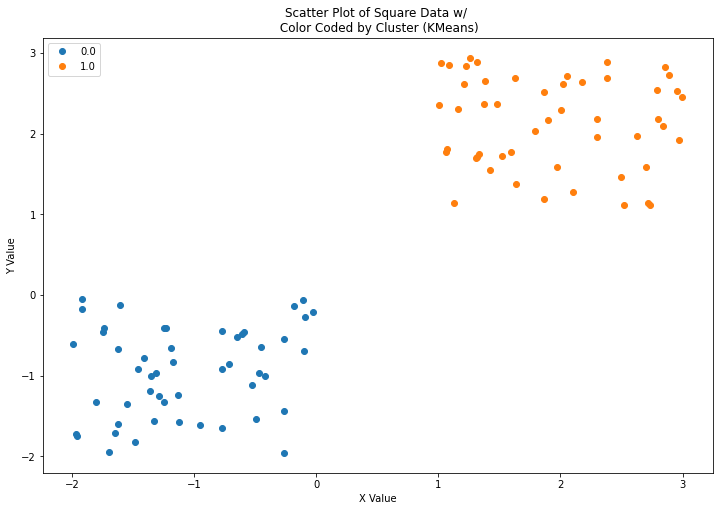

In [401]:
square['kmeans_cluster'] = result_square_kmeans
clustered_data = square.groupby("kmeans_cluster")
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
for name, group in clustered_data:
    ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
ax.legend(numpoints=1, loc='upper left')
ax.set_xlabel('X Value')
ax.set_ylabel('Y Value')
ax.set_title('Scatter Plot of Square Data w/ \n Color Coded by Cluster (KMeans)')

Text(0.5, 1.0, 'Scatter Plot of Elliptical Data w/ \n Color Coded by Cluster (KMeans)')

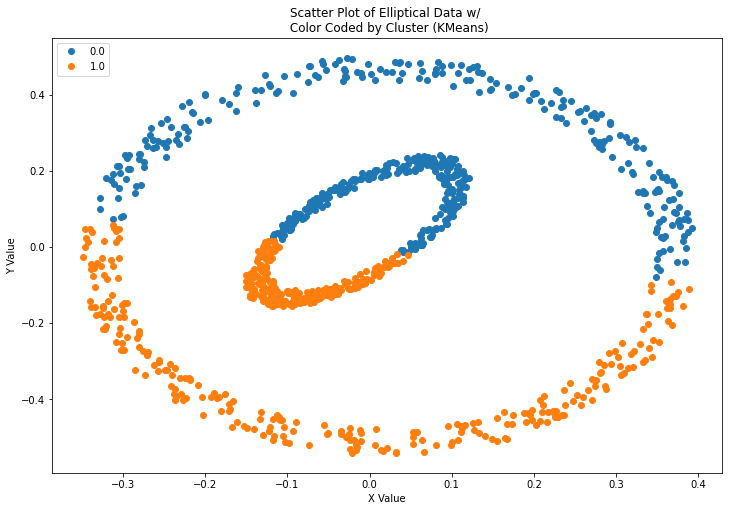

In [399]:
elliptical['kmeans_cluster'] = result_elliptical_kmeans
clustered_data = elliptical.groupby("kmeans_cluster")
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
for name, group in clustered_data:
    ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
ax.legend(numpoints=1, loc='upper left')
ax.set_xlabel('X Value')
ax.set_ylabel('Y Value')
ax.set_title('Scatter Plot of Elliptical Data w/ \n Color Coded by Cluster (KMeans)')

#### Build Spectral Clustering

Give dataset, let the similarity matrix $S_{ij}$ be the similarity between data point $i,j$. Let the Diagonal matrix $D= \sum_j S_{ij}$.

We define the **unnormalized** Laplacian matrix $L= S-D$

We define the **normalized** Laplacian matrix $L = D^{-\frac{1}{2}}LD^{-\frac{1}{2}}$

Then calculate eigenvalues and vectors of $L$, then use kmeans to cluster that result

In [ ]:
"""
You can use np.linalg.eig, library to generate degree matrix
"""

In [19]:
sim_matrix = np.zeros((len(np_square),len(np_square)))

In [46]:
def similarity_calc(data,type):
    type = type.lower()
    """
    Given two np array and the type of similarity calculation
    ---------
    Return the appropriate Similarity Matrix
    """
    sim_matrix = np.zeros((len(data),len(data)))
    if type == 'cosine':
        for i in range(len(data)):
            for j in range(len(data)):
                sim_matrix[i,j] = np.dot(data[i],data[j])/(np.linalg.norm(data[i])*(np.linalg.norm(data[j])))
    elif type == 'gaussian':
        sigma = 1
        for i in range(len(data)):
            for j in range(len(data)):
                sim_matrix[i,j] = np.exp(-distance(data[i],data[j])/(2*sigma**2))
    else:
        print("please choose 'gaussian' or 'cosine'")
    return sim_matrix

def degree_matrix(sim_matrix):
    """"
    Given a similarity matrix
    --------
    Returns the degree matrix
    """
    d_matrix = np.zeros((len(sim_matrix),len(sim_matrix)))
    for i in range(len(sim_matrix)):
        d_matrix[i,i] = sum(sim_matrix[i])    
    return d_matrix

In [ ]:
sim_matirx = similarity_calc(np_square,'cosine')
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='cosine',bandwidth=.5).fit(np_square)
result = kde.score_samples(np_square)
result = result.reshape((result.shape[0],1))
kde_d_matrix = degree_matrix(result)
l_kde= result -kde_d_matrix
eig_val_kde,eig_vec_kde = np.linalg.eig(l_kde)
eig_val = np.sort(eig_val_kde)
eig_val_kde[:k]

In [52]:
sim_matrix = similarity_calc(np_square,'cosine')
d_matrix = degree_matrix(sim_matrix)

In [68]:
l=sim_matirx - d_matrix
eig_val,eig_vec = np.linalg.eig(l)
eig_val = np.sort(eig_val)
eig_val[:k]

array([-3.35621907, -3.28197937])

In [184]:
def spectral_clustering(data,k,tol,normalization,similarity,init_random):
    """
    Spectral clustering algorithm
    Input is numpy array, tolerence,type of normalization and similarity, and k # of cluster
    ---------
    Cluster initiation is random
    ---------
    Returns list of assigned cluster for each element
    """
    s_matrix = similarity_calc(data,similarity)
    d_matrix = degree_matrix(s_matrix)
    l = s_matrix - d_matrix
    if normalization == False:
        l = (d_matrix**-.5) * l * (d_matrix**-.5) #fix code to calc non-normalized
    else: 
        pass
    eig_val,eig_vec = np.linalg.eig(l)
    k_small_eigval = np.sort(eig_val)[:k] #sort the list and get the first k elements
    # data = 
    cluster = kmeans_clustering(data,tol,k,init_random)
    return cluster

#### Fit Spectral to Both Datasets and Graph

In [ ]:
result_square_spectral = spectral_clustering(np_square,tol,k,normalization = True,similarity= 'cosine',init_random = True)
result_elliptical_spectral = spectral_clustering(np_elliptical,tol,k,normalization = True,similarity= 'cosine',init_random = True)

In [402]:
square['spectral_cluster'] = result_square_spectral
clustered_data = square.groupby("spectral_cluster")
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
for name, group in clustered_data:
    ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
ax.legend(numpoints=1, loc='upper left')
ax.set_xlabel('X Value')
ax.set_ylabel('Y Value')
ax.set_title('Scatter Plot of Square Data w/ \n Color Coded by Cluster (Spectral)')

NameError: name 'result_square_spectral' is not defined

In [403]:
elliptical['spectral_cluster'] = result_elliptical_spectral
clustered_data = elliptical.groupby("spectral_cluster")
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
for name, group in clustered_data:
    ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
ax.legend(numpoints=1, loc='upper left')
ax.set_xlabel('X Value')
ax.set_ylabel('Y Value')
ax.set_title('Scatter Plot of Elliptical Data w/ \n Color Coded by Cluster (Spectral)')

NameError: name 'result_elliptical_spectral' is not defined

### Real-World Dataset

In [156]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [241]:
"""Number of true clusters for each dataset"""
actual_k_cho = cho.ground_truth.unique().shape[0]
actual_k_iyer = iyer.ground_truth.unique().shape[0]
print(f'# Clusters Cho: {actual_k_cho} \n# Clusters iyer: {actual_k_iyer}')

# Clusters Cho: 5 
# Clusters iyer: 11


#### Fit KMeans to Cho and Iyer

##### Preprocessing

In [356]:
iyer.ground_truth.unique()
iyer_no_outliers = iyer[iyer['ground_truth']!=-1]
"""Scaling"""
sc = StandardScaler()
cho_sc_values = sc.fit_transform(cho.iloc[:,1:])
iyer_sc_values = sc.fit_transform(iyer.iloc[:,1:])

In [357]:
cho.describe()

,ground_truth,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000
mean,2.727979,-0.376075,-0.243391,0.109725,0.056933,-0.015746,-0.014622,-0.091275,-0.159617,-0.080679,0.309347,0.246399,0.150490,0.045334,-0.031842,-0.073293,-0.026399
std,1.297788,0.639312,0.633144,0.953058,0.660207,0.571665,0.504311,0.588525,0.719673,0.631758,0.640560,0.518144,0.374606,0.341869,0.380650,0.542478,0.528765
min,1.000000,-3.120000,-4.120000,-3.540000,-1.880000,-1.890000,-2.560000,-1.820000,-1.860000,-1.810000,-2.190000,-2.110000,-1.290000,-1.500000,-1.630000,-1.680000,-1.520000
25%,2.000000,-0.790000,-0.657500,-0.595000,-0.447500,-0.370000,-0.340000,-0.510000,-0.650000,-0.500000,-0.137750,-0.130000,-0.060000,-0.102750,-0.294500,-0.470000,-0.380000
50%,2.000000,-0.390000,-0.205000,0.060000,0.180000,-0.030000,-0.075000,-0.140000,-0.200000,-0.141000,0.310000,0.270000,0.170000,0.065500,-0.049000,-0.035500,0.000000
75%,4.000000,-0.022500,0.180000,0.870000,0.557500,0.370000,0.340000,0.307500,0.290000,0.317500,0.750000,0.590000,0.372250,0.230000,0.230000,0.250000,0.307500
max,5.000000,1.950000,1.430000,2.040000,1.610000,1.580000,1.480000,2.450000,2.770000,1.810000,2.160000,1.750000,1.340000,1.140000,1.480000,2.060000,2.360000


In [388]:
kmeans_iyer = kmeans_clustering(iyer_sc_values,.001,actual_k_iyer,init_random = True)
kmeans_cho = kmeans_clustering(cho_sc_values,.001,actual_k_cho,init_random= True)

In [366]:
set(kmeans_iyer-1)

{-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0}

#### Fit Spectral to Cho and Iyer

##### Preprocessing

In [211]:
kmeans_iyer = spectral_clustering(iyer.iloc[:,1:].values,.001,actual_k_iyer)
kmeans_cho = spectral_clustering(cho_sc_values,.001,actual_k_cho)

TypeError: spectral_clustering() missing 2 required positional arguments: 'normalization' and 'similarity'

#### Classification Report: KMeans

In [389]:
print('\t'*2 +'Iyer KMeans Classifcation Report \n'+ f'{classification_report(iyer.ground_truth,(kmeans_iyer),zero_division=1)}')
# print('\t'*2 +'Cho KMeans Classifcation Report \n'+ f'{classification_report(cho.ground_truth,kmeans_cho,zero_division=1)}')

		Iyer KMeans Classifcation Report 
              precision    recall  f1-score   support

        -1.0       1.00      0.00      0.00        33
         0.0       0.00      1.00      0.00         0
         1.0       0.00      0.00      0.00       100
         2.0       0.53      0.61      0.56       145
         3.0       0.02      0.03      0.02        34
         4.0       0.81      0.30      0.44        43
         5.0       0.00      0.00      0.00         7
         6.0       0.50      0.03      0.06        34
         7.0       0.00      0.00      0.00        14
         8.0       0.00      0.00      0.00        63
         9.0       0.00      0.00      0.00        19
        10.0       0.00      0.00      0.00        25

    accuracy                           0.20       517
   macro avg       0.24      0.16      0.09       517
weighted avg       0.31      0.20      0.20       517



#### Classification Report: Spectral

In [244]:
print('\t'*2 +'Iyer Spectral Classifcation Report \n'+ f'{classification_report(iyer.ground_truth,spectral_iyer,zero_division=1)}')
print('\t'*2 +'Cho Spectral Classifcation Report \n'+ f'{classification_report(cho.ground_truth,spectral_cho,zero_division=1)}')

NameError: name 'spectral_iyer' is not defined